## CPSC: 5616EL - Using PyTorch for NN

## PyTorch: The Basics

**Arrays are called tensors** in frameworks like TensorFlow and PyTorch, let's break down the terms:

**Scalar**: This is just a single number. In tensor terms, this is a 0-dimensional tensor.

**Vector**: An array of numbers. This is a 1-dimensional tensor.

**Matrix**: A 2D array of numbers. This is a 2-dimensional tensor.

Tensor (in the general sense): An N-dimensional array of numbers. When N=0, it's a scalar. When N=1, it's a vector. When N=2, it's a matrix.

PyTorch allows you to dynamically define computational graphs. This is done by operating on PyTorch Tensor objects.

https://pytorch.org/get-started/pytorch-2.0/



In [ ]:
# PyTorch library, which provides tensor computation and deep neural networks
import torch
# torchvision consists of popular datasets, model architectures, and common image transformations for computer vision tasks
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import numpy as np
# Import tqdm, a library to show progress bars in Jupyter Notebooks
from tqdm.notebook import tqdm
print(torch.__version__)

2.1.0+cu118


A few other useful imports for debugging and visualizations.

In [ ]:
!pip install ipdb
!pip install torchviz
!apt install graphviz
import ipdb
from torchviz import make_dot

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 9.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4130 sha256=6f6a2154562cefe9b539ceb9a57c721ca7e5766803f11845395123b37a4f1581
  Stored in directory: /root/.cache/pip/wheels/4c/97/88/a02973217949e0db0c9f4346d154085f4725f99c4f15a87094
Successfully built torchviz
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
graphviz is already the newest version (2.42.2-6).
0 upgraded, 0 newly installed, 0 to remove and 19 not upgraded.


Here is an example, where we work with the function

$$f(x) = x^2 + 2x + 6$$

Note how there is nothing special about this function in terms of PyTorch specific syntax, i.e. you could apply this to any object that implements the `**`, `*` and `+` operators.



We need to set `requires_grad` property to true. By default, during the forward pass, i.e. when evaluating f(x), an operation is recorded in the backward graph, only if at least one of its input tensors requires a gradient. By setting requires_grad=True, PyTorch tracks all operations on this tensor x so that you can compute gradients later. This tells PyTorch to keep track of the computation graph for this tensor, which is necessary for backpropagation.

In [ ]:
def f(x):
    return x ** 2 + 2 * x + 6

Now let's compute the derivative $$\frac{d}{dx}\bigg\rvert_{x=4} f(x) = 2(4) + 2 = 10$$

In [ ]:
np_x = np.array([4.0])
x = torch.from_numpy(np_x).requires_grad_(True) # Converts the NumPy array into a PyTorch tensor. Need to set requires_grad to True
y = f(x) # based on the function we defined:  x ** 2 + 2 * x + 6

y.backward() # backpropagation, PyTorch computes the gradient of y

print(x.grad)  # This will print the gradient dy/dx at x = 4.0

tensor([10.], dtype=torch.float64)


We can visualize the computation graph by calling the `make_dot` function from `torchviz`. There are

* 2 Addition Operations
* 1 Power Operation
* 1 Multiply Operation
* 1 Accumulate Operation

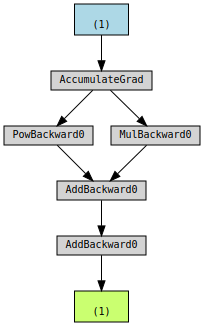

In [ ]:
make_dot(y)

If we instead evaluate $$\frac{d}{dx}\bigg\rvert_{x=5} f(x) = 2(5) + 2 = 12$$

In [ ]:
np_x = np.array([5.0])
x = torch.from_numpy(np_x).requires_grad_(True) # Need to set requires_grad to True
y = f(x)

y.backward()

print(x.grad)  # This will print the gradient dy/dx at x = 5.0

tensor([12.], dtype=torch.float64)


## MNIST dataset classification using Neural Networks

This program will download the [MNIST dataset](https://en.wikipedia.org/wiki/MNIST_database), create a simple feedforward neural network with one hidden layer, train it for 5 epochs, and then test its accuracy on the test set. The neural network architecture used here is just a basic example, and many enhancements can be made for improving the performance.

Input layer: 28x28 = 784 neurons (matching the size of a flattened MNIST image)

One hidden layer: 500 neurons (as specified by the hidden_size variable)

Output layer: 10 neurons (one for each digit from 0 to 9)

MNIST training dataset, which consists of 60,000 images. When a batch_size of 100 is used, meaning each batch will contain 100 images.

When using torchvision.datasets.MNIST, the training set is split into 60,000 samples, and the test set is split into 10,000 samples by default based on the train argument. If train=True, it fetches the training data, and if train=False, it fetches the test data.

In [ ]:
# Define hyperparameters
input_size = 28*28  # Size of image (28x28 pixels for MNIST)
hidden_size = 500   # Size of hidden layer ( a single hidden layer with 500 neurons)
num_classes = 10    # Number of output classes (0-9 for MNIST)
num_epochs = 5      # Number of times the entire dataset is processed
batch_size = 100    # Number of samples per gradient update (for SGD)
learning_rate = 0.001

# Download the MNIST dataset for training, store it in the 'data' directory, and apply a transform that
# converts images into tensors.

# Define data transformations and normalization for MNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# Load the MNIST dataset
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transform)

# Create data loaders for batching (100) and shuffling the datasets
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

print(train_dataset) # Print the representation of the train_loader object


100%|██████████| 9912422/9912422 [00:00<00:00, 87834030.31it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 39807983.51it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 30760125.95it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 6401387.35it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )


We can easily visualize the images and their corresponding label as below. See how index 0 for a given sample corresponds to the image, and index 1 is the label. Each image is represented as a vector of 28 × 28 = 784 pixel values.

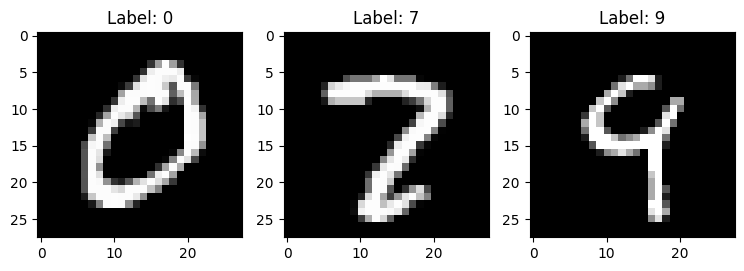

In [ ]:
# Define a list of indices for which we want to visualize the corresponding MNIST images.
indices = [1, 12000, 344] # three instances - labels: 0, 7, 9

# for showing the figure with a specified size
fig = plt.figure(figsize=(len(indices) * 3, 3))

# Loop over each index in the 'indices' list.
for i, index in enumerate(indices):
    # For each index, add a new subplot to the figure.
    ax = fig.add_subplot(1, len(indices), i + 1)

    # Fetch the MNIST example (image and label) for the given index.
    example = train_dataset[index]

    # Display the image in the current subplot.
    # 'example[0]' is the image which we reshape from its tensor form to a 28x28 numpy array.
    # And specify the colormap to be grayscale.
    ax.imshow(example[0].reshape(28, 28), cmap=plt.cm.gray)

    # Set the title of the current subplot to the label of the image.
    ax.set_title("Label: {}".format(example[1]))

## Training

In [ ]:
# Check if a GPU is available and set the device accordingly.
if torch.cuda.is_available():
    print("Using cuda")
    use_cuda = True
    device = torch.device("cuda")
else:
    device = "cpu"

# Define the neural network architecture
# 2-layer MLP: 1 hidden layer with ReLu + 1 output layer
class Net(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(Net, self).__init__()
        # PyTorch will automatically initializes the weights and biases with requires_grad=True when using nn.Linear
        # Fully connected layer from input to hidden layer
        self.fc1 = nn.Linear(input_size, hidden_size) # input size = 28*28 = 1024, hidden layer = 500
        # Activation function: ReLU (Rectified Linear Unit)
        self.relu = nn.ReLU()
        # Fully connected layer from hidden layer to output
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        # Pass input through first fully connected layer and then apply ReLU activation
        # out : z
        out = self.fc1(x)
        out = self.relu(out)
        # Pass the result through the second fully connected layer
        out = self.fc2(out)
        return out

# Create an instance of the neural network model
model = Net(input_size, hidden_size, num_classes)

# Define the loss function (Cross Entropy Loss for multivariate classification problems)
criterion = nn.CrossEntropyLoss()
# Define the optimizer (Stochastic Gradient Descent with momentum)
# momentum: helps to accelerate convergence by using past gradients to keep the optimization moving in the same direction.
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

# Lists to track progress
train_losses = []
test_losses = []
test_accuracies = []

# Train the model
for epoch in range(num_epochs):

    for i, (images, labels) in enumerate(train_loader): # loading from the train dataset
        # Flatten the images into 1D vectors from 2D
        images = images.view(-1, 28*28)

        # start the training
        optimizer.zero_grad() # Clears the gradients from the previous batch to ensure gradients from previous batches do not accumulate.
        outputs = model(images) # Forward Pass: The input images are passed through the network to get the predicted outputs.
        loss = criterion(outputs, labels) # Cross Entropy Loss
        loss.backward() # Computes the gradients of the loss with respect to each weight and bias in the network (backpropagation)
        optimizer.step() # Updates the weights and bises using SGD

        # Print loss statistics every 100 batches
        if (i+1) % 100 == 0:
            print ('Epoch: [{}/{}], Step: [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, i+1, len(train_loader), loss.item()))

    # Track training loss after each epoch
    train_losses.append(loss.item())

Using cuda
Epoch: [1/5], Step: [100/600], Loss: 1.4692
Epoch: [1/5], Step: [200/600], Loss: 0.8713
Epoch: [1/5], Step: [300/600], Loss: 0.7824
Epoch: [1/5], Step: [400/600], Loss: 0.5451
Epoch: [1/5], Step: [500/600], Loss: 0.5584
Epoch: [1/5], Step: [600/600], Loss: 0.4036
Epoch: [2/5], Step: [100/600], Loss: 0.4039
Epoch: [2/5], Step: [200/600], Loss: 0.5249
Epoch: [2/5], Step: [300/600], Loss: 0.3536
Epoch: [2/5], Step: [400/600], Loss: 0.3321
Epoch: [2/5], Step: [500/600], Loss: 0.3535
Epoch: [2/5], Step: [600/600], Loss: 0.2947
Epoch: [3/5], Step: [100/600], Loss: 0.4119
Epoch: [3/5], Step: [200/600], Loss: 0.2517
Epoch: [3/5], Step: [300/600], Loss: 0.3310
Epoch: [3/5], Step: [400/600], Loss: 0.3828
Epoch: [3/5], Step: [500/600], Loss: 0.5345
Epoch: [3/5], Step: [600/600], Loss: 0.2530
Epoch: [4/5], Step: [100/600], Loss: 0.2576
Epoch: [4/5], Step: [200/600], Loss: 0.4453
Epoch: [4/5], Step: [300/600], Loss: 0.4671
Epoch: [4/5], Step: [400/600], Loss: 0.2608
Epoch: [4/5], Step: [

## Evaluate the trained model on test data

In [ ]:

# Begin evaluation phase for the trained model on test data
correct = 0   # Initialize counter for correct predictions
total = 0     # Initialize counter for total number of images tested

# Lists to store true labels and model predictions for all test images
all_labels = []
all_predictions = []

# torch.no_grad() ensures that operations inside this context won't track gradients.
# This is useful when evaluating a model because we don't need gradients computation during inference.
with torch.no_grad():

    for images, labels in test_loader: # loading from the test dataset 10000
        # Reshape the images into a 1D vector to be compatible with the model input
        images = images.view(-1, 28*28)

        # Pass images through the model to get predicted outputs
        outputs = model(images)

        # Determine the class with the highest predicted score
        _, predicted = torch.max(outputs.data, 1)

        # Update the total count and the count of correct predictions
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Store true labels and predicted labels for this batch
        all_labels.extend(labels.numpy())
        all_predictions.extend(predicted.numpy())

# Print overall accuracy of the model on test data
print('\nAccuracy of the network on the 10000 test images: {} %\n'.format(100 * correct / total))

# Use scikit-learn's classification report to get detailed metrics like precision, recall, etc.
# The report provides these metrics for each class and averages.
print(classification_report(all_labels, all_predictions, target_names=[str(i) for i in range(10)]))


Accuracy of the network on the 10000 test images: 92.14 %

              precision    recall  f1-score   support

           0       0.94      0.98      0.96       980
           1       0.97      0.97      0.97      1135
           2       0.93      0.89      0.91      1032
           3       0.91      0.90      0.91      1010
           4       0.91      0.93      0.92       982
           5       0.90      0.87      0.89       892
           6       0.93      0.94      0.94       958
           7       0.93      0.92      0.93      1028
           8       0.87      0.90      0.89       974
           9       0.90      0.90      0.90      1009

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000



# Visualize the classification weights after training

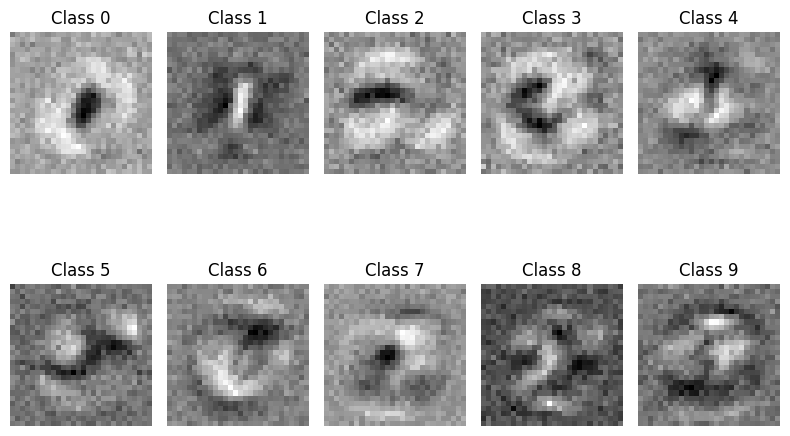

In [ ]:
# Get the weights of the first fully connected layer (from input to hidden layer)
weights = model.fc1.weight.data

# Create a 2x5 grid of subplots for visualizing the weights for each class (0 to 9)
fig, axarr = plt.subplots(2, 5, figsize=(8, 6))

# Iterate over all classes (from 0 to 9)
for idx in range(10):
    # Select the appropriate subplot for the current class
    ax = axarr[idx // 5, idx % 5]

    # Combine the weights from the first layer with the weights connecting the hidden layer to the current class
    # This provides a higher-level view of the learned patterns for the current class
    class_weights = torch.matmul(model.fc2.weight[idx], weights)

    # Visualize the computed weights for the current class as a 28x28 image
    ax.imshow(class_weights.view(28, 28).detach().numpy(), cmap="gray")

    # Turn off axis to have a cleaner visualization
    ax.axis('off')

    # Set title to indicate which class is being visualized
    ax.set_title(f'Class {idx}')

# Adjust spacing between subplots for better visualization
plt.tight_layout()

# Display the visualizations
plt.show()